In [36]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [37]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [38]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
monitor_position =  1 / fcen * 2
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

Sx = tpml+width_bot_ag+tpml
Sy = round(tag_bot+tag_side+design_region_height+monitor_position+monitor_blank+tpml, 1)

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
# Ny = int(design_region_resolution * design_region_height) + 1
Ny = 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [134]:
# 셀 크기 설정
cell_size = mp.Vector3(Sx, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [184]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [185]:
num_sources = 3
spacing = 10 / resolution  

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(offset, center_y_source_position, 0)
    )
    for offset in offsets
]

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag]
    )
    for src in sources
]

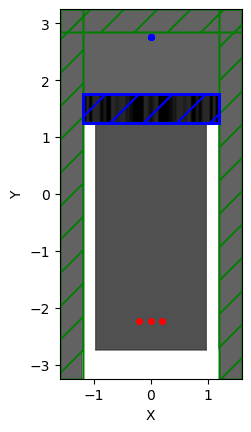

In [188]:
monitor_position_J = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(0, 0)

FourierFields_list = [
    mpa.FourierFields(
        sims[i],  
        mp.Volume(center=monitor_position_J, size=monitor_size),
        mp.Ez,
        yee_grid=True
    )
    for i in range(num_sources)
]

def J(fields):
    return npa.sum(npa.real(fields) ** 2)

opt_list = [
    mpa.OptimizationProblem(
        simulation          = sims[i],
        objective_functions = [J],
        objective_arguments = [FourierFields_list[i]],
        design_regions      = [design_region],
        frequencies         = [fcen],
        maximum_run_time    = 100
    )
    for i in range(num_sources)
]


for i in range(num_sources):
    opt_list[i].plot2D(True)
    

In [27]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
         
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [28]:
eta_i = 0.5

def multi_mapping(x, eta, beta):    
    size_each = Nx * Ny

    v3 = x.reshape(layer_num, size_each)

    rho_list = []
    for i in range(layer_num):
        layer_field = v3[i].reshape(Nx, Ny)
        sym_field   = (layer_field[::-1, :] + layer_field) / 2
        flat        = sym_field.ravel()
        proj        = mpa.tanh_projection(flat, beta, eta)
        rho_list.append(proj)

    return npa.concatenate(rho_list, axis=0)



--- Iter 1 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [7.652564617977035e-05, 0.0513259534242955, 7.652564617977408e-05]
Mean FoM: 0.017160
Binarization degree: 0.0894


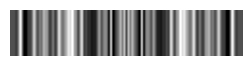


--- Iter 2 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [4.4843024736144466e-05, 0.05430115878672378, 4.484302473614926e-05]
Mean FoM: 0.018130
Binarization degree: 0.0903


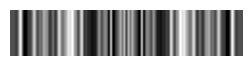


--- Iter 3 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [8.949924653346171e-06, 0.0602143086860455, 8.949924653346885e-06]
Mean FoM: 0.020077
Binarization degree: 0.0928


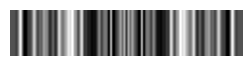


--- Iter 4 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [3.858991947424763e-06, 0.06871829307770208, 3.858991947424558e-06]
Mean FoM: 0.022909
Binarization degree: 0.0977


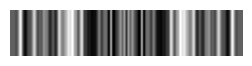


--- Iter 5 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [5.7347850973129824e-05, 0.07850136498711867, 5.734785097312896e-05]
Mean FoM: 0.026205
Binarization degree: 0.1056


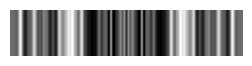


--- Iter 6 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.00023599274408303276, 0.0894551721044949, 0.00023599274408303222]
Mean FoM: 0.029976
Binarization degree: 0.1163


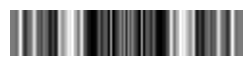


--- Iter 7 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0007489514911321004, 0.10309891513702206, 0.000748951491132093]
Mean FoM: 0.034866
Binarization degree: 0.1297


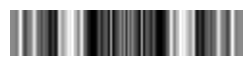


--- Iter 8 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.001850780210554581, 0.11717284426860561, 0.0018507802105545772]
Mean FoM: 0.040291
Binarization degree: 0.1461


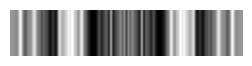


--- Iter 9 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.003616939593158189, 0.13198982063407044, 0.0036169395931581437]
Mean FoM: 0.046408
Binarization degree: 0.1692


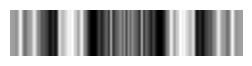


--- Iter 10 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.005622782168647041, 0.1491116959464564, 0.005622782168647033]
Mean FoM: 0.053452
Binarization degree: 0.1985


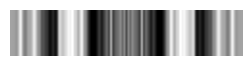


--- Iter 11 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0065176097692332445, 0.16038552931962238, 0.006517609769233236]
Mean FoM: 0.057807
Binarization degree: 0.2305


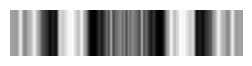


--- Iter 12 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.006733582764861359, 0.16951554539849606, 0.006733582764861323]
Mean FoM: 0.060994
Binarization degree: 0.2579


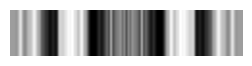


--- Iter 13 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.007375348189042206, 0.18472502120166107, 0.007375348189042248]
Mean FoM: 0.066492
Binarization degree: 0.2818


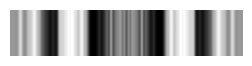


--- Iter 14 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.008750387364726182, 0.20777952300683528, 0.008750387364726234]
Mean FoM: 0.075093
Binarization degree: 0.3037


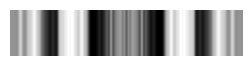


--- Iter 15 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.01115003999307705, 0.23889090135118612, 0.011150039993077043]
Mean FoM: 0.087064
Binarization degree: 0.3244


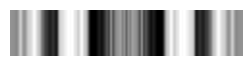


--- Iter 16 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.014771215673849987, 0.27408502551507224, 0.014771215673850051]
Mean FoM: 0.101209
Binarization degree: 0.3445


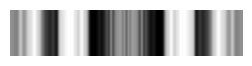


--- Iter 17 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.01943625632087549, 0.3015729919193622, 0.01943625632087553]
Mean FoM: 0.113482
Binarization degree: 0.3672


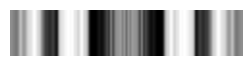


--- Iter 18 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.024306221636745576, 0.32366690211498683, 0.02430622163674561]
Mean FoM: 0.124093
Binarization degree: 0.3933


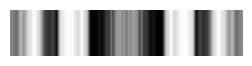


--- Iter 19 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.02838448250762617, 0.34692287053662163, 0.02838448250762627]
Mean FoM: 0.134564
Binarization degree: 0.4191


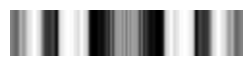


--- Iter 20 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.03128947948130429, 0.3770880141367272, 0.03128947948130436]
Mean FoM: 0.146556
Binarization degree: 0.4459


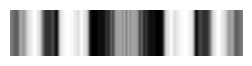


--- Iter 21 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.03318594951038946, 0.4192645468270913, 0.03318594951038949]
Mean FoM: 0.161879
Binarization degree: 0.4720


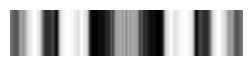


--- Iter 22 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.033943493769226646, 0.4713084880151494, 0.03394349376922667]
Mean FoM: 0.179732
Binarization degree: 0.4969


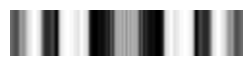


--- Iter 23 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.03330170714537684, 0.5236746437770035, 0.03330170714537705]
Mean FoM: 0.196759
Binarization degree: 0.5217


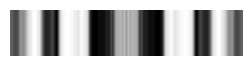


--- Iter 24 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.03185574425149908, 0.567071022374866, 0.03185574425149942]
Mean FoM: 0.210261
Binarization degree: 0.5447


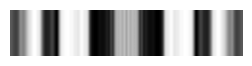


--- Iter 25 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.03049136587910401, 0.5890085064230378, 0.030491365879103956]
Mean FoM: 0.216664
Binarization degree: 0.5643


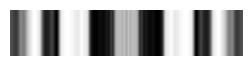


--- Iter 26 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.030744083386430324, 0.571443762930486, 0.03074408338643041]
Mean FoM: 0.210977
Binarization degree: 0.5800


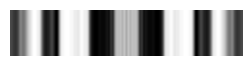


--- Iter 27 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.029736595821867, 0.5507955420501154, 0.029736595821867]
Mean FoM: 0.203423
Binarization degree: 0.5882


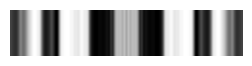


--- Iter 28 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.035303779155794156, 0.6249432147377635, 0.03530377915579404]
Mean FoM: 0.231850
Binarization degree: 0.5926


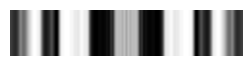


--- Iter 29 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.03681266217994054, 0.5666082712394152, 0.0368126621799407]
Mean FoM: 0.213411
Binarization degree: 0.5956


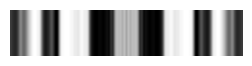


--- Iter 30 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.041038471343903135, 0.6442048541979836, 0.041038471343903496]
Mean FoM: 0.242094
Binarization degree: 0.5976


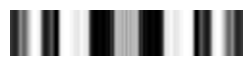


--- Iter 31 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0419435732179618, 0.6404137925965088, 0.04194357321796184]
Mean FoM: 0.241434
Binarization degree: 0.5998


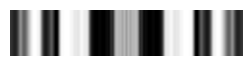


--- Iter 32 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0453611166881095, 0.6646462363877373, 0.04536111668810965]
Mean FoM: 0.251789
Binarization degree: 0.6018


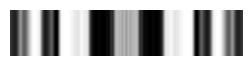


--- Iter 33 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04714105001661536, 0.649145748762619, 0.047141050016615636]
Mean FoM: 0.247809
Binarization degree: 0.6041


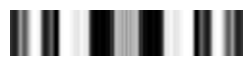


--- Iter 34 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04711355082931529, 0.6338050320082093, 0.04711355082931549]
Mean FoM: 0.242677
Binarization degree: 0.6072


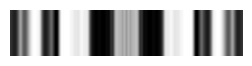


--- Iter 35 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04870481239064744, 0.6867986352487291, 0.048704812390647646]
Mean FoM: 0.261403
Binarization degree: 0.6107


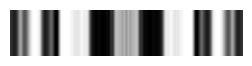


--- Iter 36 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04729418525639889, 0.6865456248598477, 0.04729418525639933]
Mean FoM: 0.260378
Binarization degree: 0.6146


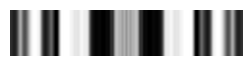


--- Iter 37 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04741578979210286, 0.7111753100711906, 0.04741578979210302]
Mean FoM: 0.268669
Binarization degree: 0.6183


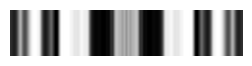


--- Iter 38 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0467959750862688, 0.7121534169724157, 0.04679597508626919]
Mean FoM: 0.268582
Binarization degree: 0.6218


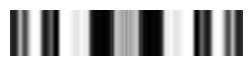


--- Iter 39 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.045490226694744854, 0.7146918794360746, 0.04549022669474515]
Mean FoM: 0.268557
Binarization degree: 0.6256


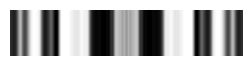


--- Iter 40 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.045017930981854956, 0.7615580902939926, 0.045017930981855185]
Mean FoM: 0.283865
Binarization degree: 0.6293


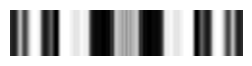


--- Iter 41 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04275689193154975, 0.7629305661754283, 0.042756891931550065]
Mean FoM: 0.282815
Binarization degree: 0.6328


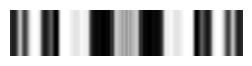


--- Iter 42 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04291256010603842, 0.7860618938694213, 0.04291256010603857]
Mean FoM: 0.290629
Binarization degree: 0.6360


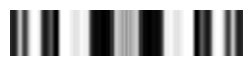


--- Iter 43 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04204522149020558, 0.7695259686015773, 0.04204522149020576]
Mean FoM: 0.284539
Binarization degree: 0.6389


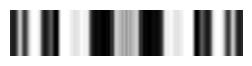


--- Iter 44 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04184983861633098, 0.7959836285668946, 0.041849838616331285]
Mean FoM: 0.293228
Binarization degree: 0.6415


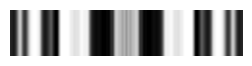


--- Iter 45 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.040617238835536244, 0.7931370252884841, 0.04061723883553639]
Mean FoM: 0.291457
Binarization degree: 0.6443


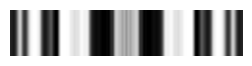


--- Iter 46 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.041934764101081094, 0.8076049472441469, 0.0419347641010813]
Mean FoM: 0.297158
Binarization degree: 0.6471


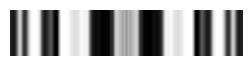


--- Iter 47 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04267438189876566, 0.7916957766336559, 0.04267438189876604]
Mean FoM: 0.292348
Binarization degree: 0.6494


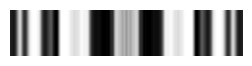


--- Iter 48 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04389151383945913, 0.8126150082561032, 0.0438915138394592]
Mean FoM: 0.300133
Binarization degree: 0.6512


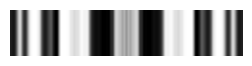


--- Iter 49 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04445832596975633, 0.807256337837122, 0.0444583259697565]
Mean FoM: 0.298724
Binarization degree: 0.6527


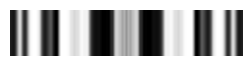


--- Iter 50 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.046451641087518175, 0.8143582255974798, 0.04645164108751853]
Mean FoM: 0.302421
Binarization degree: 0.6547


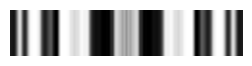


--- Iter 51 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.047253926042758486, 0.8027497794316785, 0.047253926042758694]
Mean FoM: 0.299086
Binarization degree: 0.6566


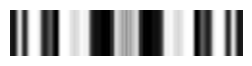


--- Iter 52 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04824497480156024, 0.8174872826813843, 0.048244974801560626]
Mean FoM: 0.304659
Binarization degree: 0.6584


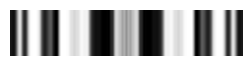


--- Iter 53 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0486091428919541, 0.8172049039684952, 0.04860914289195467]
Mean FoM: 0.304808
Binarization degree: 0.6604


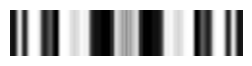


--- Iter 54 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04898288929096942, 0.8145107847729186, 0.04898288929096971]
Mean FoM: 0.304159
Binarization degree: 0.6629


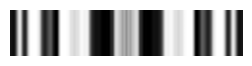


--- Iter 55 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.049040616968254354, 0.8240209597078958, 0.049040616968254624]
Mean FoM: 0.307367
Binarization degree: 0.6654


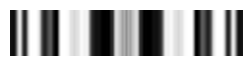


--- Iter 56 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.048375053489108734, 0.8292458574668685, 0.04837505348910903]
Mean FoM: 0.308665
Binarization degree: 0.6679


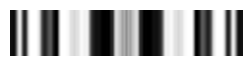


--- Iter 57 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.048397842072804315, 0.8381019725082604, 0.04839784207280453]
Mean FoM: 0.311633
Binarization degree: 0.6708


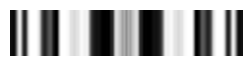


--- Iter 58 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04794163044835255, 0.8367768162665183, 0.047941630448353006]
Mean FoM: 0.310887
Binarization degree: 0.6737


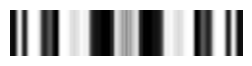


--- Iter 59 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04747151129075547, 0.8464518180649002, 0.04747151129075567]
Mean FoM: 0.313798
Binarization degree: 0.6760


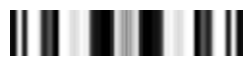


--- Iter 60 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04763518624699224, 0.8516764913013634, 0.047635186246992395]
Mean FoM: 0.315649
Binarization degree: 0.6783


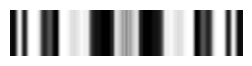


--- Iter 61 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.047988902506099065, 0.8485741789066993, 0.04798890250609926]
Mean FoM: 0.314851
Binarization degree: 0.6809


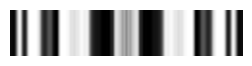


--- Iter 62 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04852530573360398, 0.85788013267274, 0.0485253057336044]
Mean FoM: 0.318310
Binarization degree: 0.6832


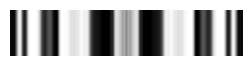


--- Iter 63 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.049544958577635766, 0.8613466634636453, 0.0495449585776361]
Mean FoM: 0.320146
Binarization degree: 0.6855


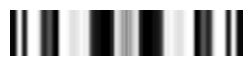


--- Iter 64 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.050848767082737216, 0.8588117471105924, 0.05084876708273748]
Mean FoM: 0.320170
Binarization degree: 0.6878


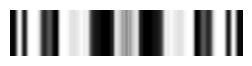


--- Iter 65 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.05209319408700086, 0.8667590073760985, 0.052093194087001214]
Mean FoM: 0.323648
Binarization degree: 0.6896


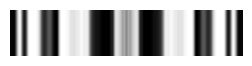


--- Iter 66 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.05339171289049401, 0.868505386533377, 0.053391712890494526]
Mean FoM: 0.325096
Binarization degree: 0.6913


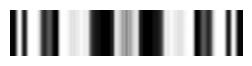


--- Iter 67 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.05467641625080135, 0.8650782998450288, 0.05467641625080157]
Mean FoM: 0.324810
Binarization degree: 0.6929


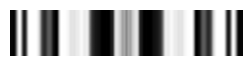


--- Iter 68 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.055622294399102164, 0.871606792305198, 0.05562229439910271]
Mean FoM: 0.327617
Binarization degree: 0.6942


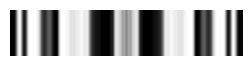


--- Iter 69 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.056410376019493724, 0.8734420828068288, 0.05641037601949413]
Mean FoM: 0.328754
Binarization degree: 0.6956


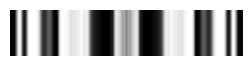


--- Iter 70 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.05704228520537088, 0.8711131612517438, 0.05704228520537145]
Mean FoM: 0.328399
Binarization degree: 0.6971


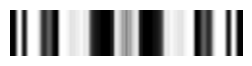


--- Iter 71 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.05741269962864126, 0.8782859857795896, 0.05741269962864177]
Mean FoM: 0.331037
Binarization degree: 0.6982


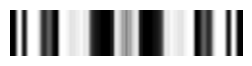


--- Iter 72 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0577646296565129, 0.8809928828832702, 0.05776462965651327]
Mean FoM: 0.332174
Binarization degree: 0.6994


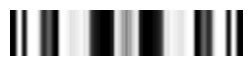


--- Iter 73 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.180
FoM values: [0.058017334793055264, 0.8806397830186004, 0.0580173347930557]
Mean FoM: 0.332225
Binarization degree: 0.7005


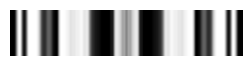


--- Iter 74 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.180
FoM values: [0.05521126109064295, 0.8751538987910293, 0.055211261090643254]
Mean FoM: 0.328525
Binarization degree: 0.7108


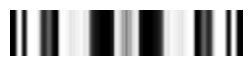


--- Iter 75 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.180
FoM values: [0.057041783660546574, 0.867095405545689, 0.05704178366054705]
Mean FoM: 0.327060
Binarization degree: 0.7114


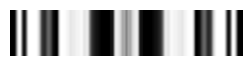


--- Iter 76 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.180
FoM values: [0.059355575737829624, 0.894802215322478, 0.05935557573782988]
Mean FoM: 0.337838
Binarization degree: 0.7108


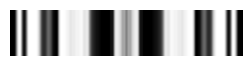


--- Iter 77 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.180
FoM values: [0.06232603414989561, 0.9028852462419884, 0.06232603414989617]
Mean FoM: 0.342512
Binarization degree: 0.7103


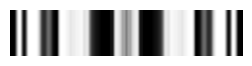


--- Iter 78 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.180
FoM values: [0.06435705973083222, 0.8908714282450204, 0.06435705973083285]
Mean FoM: 0.339862
Binarization degree: 0.7099


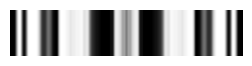


--- Iter 79 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.180
FoM values: [0.0659096523201827, 0.9025112436872079, 0.06590965232018318]
Mean FoM: 0.344777
Binarization degree: 0.7093


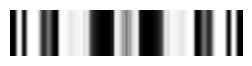


--- Iter 80 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.180
FoM values: [0.06720884478652046, 0.905077808881309, 0.06720884478652119]
Mean FoM: 0.346498
Binarization degree: 0.7088


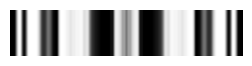


--- Iter 81 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.0673079612558048, 0.9028330645605054, 0.06730796125580564]
Mean FoM: 0.345816
Binarization degree: 0.7085


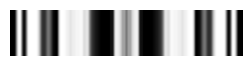


--- Iter 82 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.06292989618612471, 0.8988710456459802, 0.06292989618612474]
Mean FoM: 0.341577
Binarization degree: 0.7183


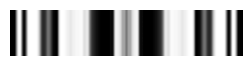


--- Iter 83 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.062064671373106096, 0.8465682319760433, 0.0620646713731067]
Mean FoM: 0.323566
Binarization degree: 0.7185


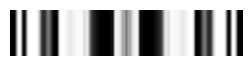


--- Iter 84 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.06494362653746615, 0.9189274454511123, 0.0649436265374668]
Mean FoM: 0.349605
Binarization degree: 0.7173


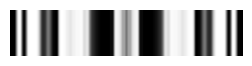


--- Iter 85 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.06536309740721943, 0.9101359576200497, 0.06536309740721989]
Mean FoM: 0.346954
Binarization degree: 0.7165


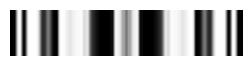


--- Iter 86 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.06600962844993688, 0.8678698755743154, 0.0660096284499374]
Mean FoM: 0.333296
Binarization degree: 0.7168


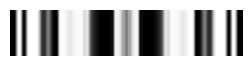


--- Iter 87 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.07005745274953354, 0.9314416572861739, 0.07005745274953407]
Mean FoM: 0.357186
Binarization degree: 0.7158


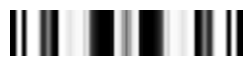


--- Iter 88 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.06924613768344634, 0.9042839428065752, 0.06924613768344708]
Mean FoM: 0.347592
Binarization degree: 0.7148


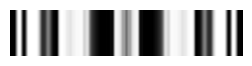


--- Iter 89 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.07082379612108088, 0.8898460358033907, 0.07082379612108158]
Mean FoM: 0.343831
Binarization degree: 0.7152


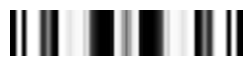


--- Iter 90 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.07352800547409949, 0.929725595487425, 0.07352800547410022]
Mean FoM: 0.358927
Binarization degree: 0.7144


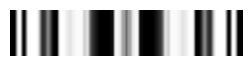


--- Iter 91 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.0706197219150071, 0.8938286465689217, 0.07061972191500719]
Mean FoM: 0.345023
Binarization degree: 0.7130


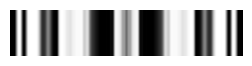


--- Iter 92 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.07352751443365749, 0.9219832455646416, 0.07352751443365806]
Mean FoM: 0.356346
Binarization degree: 0.7136


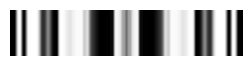


--- Iter 93 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.07348732284276988, 0.92489210644422, 0.07348732284277062]
Mean FoM: 0.357289
Binarization degree: 0.7131


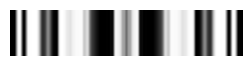


--- Iter 94 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.07165328313830915, 0.9163134152381032, 0.07165328313830947]
Mean FoM: 0.353207
Binarization degree: 0.7117


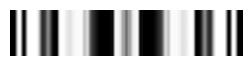


--- Iter 95 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.07406273297779081, 0.9514993297566452, 0.07406273297779141]
Mean FoM: 0.366542
Binarization degree: 0.7120


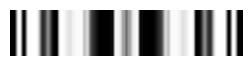


--- Iter 96 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.07275591611549884, 0.9335260100572685, 0.07275591611549918]
Mean FoM: 0.359679
Binarization degree: 0.7118


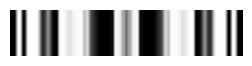


--- Iter 97 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.07289408412803043, 0.9495127429006404, 0.07289408412803092]
Mean FoM: 0.365100
Binarization degree: 0.7109


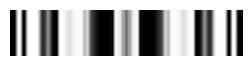


--- Iter 98 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.07397500931825009, 0.9662187976384239, 0.07397500931825045]
Mean FoM: 0.371390
Binarization degree: 0.7108


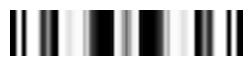


--- Iter 99 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.07317819277015523, 0.9505254662868997, 0.07317819277015596]
Mean FoM: 0.365627
Binarization degree: 0.7107


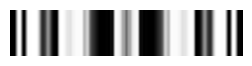


--- Iter 100 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.07423832665548688, 0.9705181007838105, 0.07423832665548749]
Mean FoM: 0.372998
Binarization degree: 0.7100


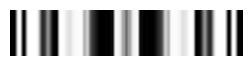


--- Iter 101 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.07460855860917816, 0.9733568274960652, 0.07460855860917877]
Mean FoM: 0.374191
Binarization degree: 0.7096


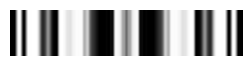


--- Iter 102 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.07453831350070564, 0.9647480871843006, 0.0745383135007064]
Mean FoM: 0.371275
Binarization degree: 0.7096


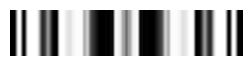


--- Iter 103 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.07562936324640396, 0.9802101312005147, 0.07562936324640457]
Mean FoM: 0.377156
Binarization degree: 0.7089


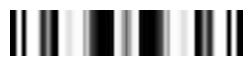


--- Iter 104 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.07567993052277486, 0.977181398621499, 0.0756799305227754]
Mean FoM: 0.376180
Binarization degree: 0.7085


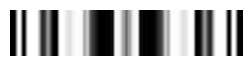


--- Iter 105 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.607
FoM values: [0.07590995552880753, 0.9712834575250258, 0.0759099555288085]
Mean FoM: 0.374368
Binarization degree: 0.7085


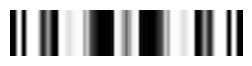


--- Iter 106 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.607
FoM values: [0.07615281845198035, 0.976152659892035, 0.07615281845198085]
Mean FoM: 0.376153
Binarization degree: 0.7185


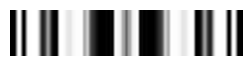


--- Iter 107 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.607
FoM values: [0.07676606467231525, 0.9873281759730854, 0.07676606467231654]
Mean FoM: 0.380287
Binarization degree: 0.7178


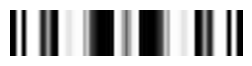


--- Iter 108 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.607
FoM values: [0.07670576919415481, 0.988245542601489, 0.07670576919415545]
Mean FoM: 0.380552
Binarization degree: 0.7166


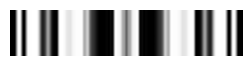


--- Iter 109 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.607
FoM values: [0.07586784194178253, 0.9795478403538379, 0.07586784194178291]
Mean FoM: 0.377095
Binarization degree: 0.7150


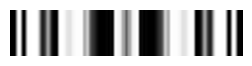


--- Iter 110 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.607
FoM values: [0.0763695538688978, 0.9798750623129844, 0.07636955386889835]
Mean FoM: 0.377538
Binarization degree: 0.7140


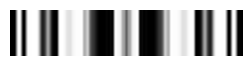


--- Iter 111 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.607
FoM values: [0.07631770187082877, 0.9730219047941642, 0.07631770187082969]
Mean FoM: 0.375219
Binarization degree: 0.7126


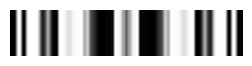


--- Iter 112 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.607
FoM values: [0.07640641045365613, 0.9610033959543868, 0.07640641045365663]
Mean FoM: 0.371272
Binarization degree: 0.7116


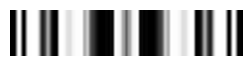


--- Iter 113 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.607
FoM values: [0.07825044576885747, 0.9595007306186739, 0.07825044576885815]
Mean FoM: 0.372001
Binarization degree: 0.7115


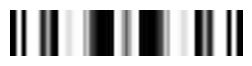


--- Iter 114 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.860
FoM values: [0.07874117952098415, 0.953946242521336, 0.07874117952098474]
Mean FoM: 0.370476
Binarization degree: 0.7110


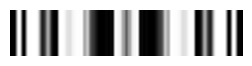


--- Iter 115 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.860
FoM values: [0.08351001263683111, 0.9824985484568094, 0.08351001263683175]
Mean FoM: 0.383173
Binarization degree: 0.7229


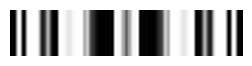


--- Iter 116 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.860
FoM values: [0.08231670119280114, 0.9582191499388408, 0.0823167011928022]
Mean FoM: 0.374284
Binarization degree: 0.7231


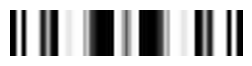


--- Iter 117 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.860
FoM values: [0.08460629617700201, 0.980012120788274, 0.08460629617700285]
Mean FoM: 0.383075
Binarization degree: 0.7228


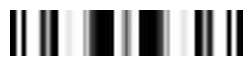


--- Iter 118 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.860
FoM values: [0.08446731873462075, 0.9920404458712868, 0.08446731873462139]
Mean FoM: 0.386992
Binarization degree: 0.7222


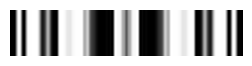


--- Iter 119 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.860
FoM values: [0.08199360087510038, 0.982265202938143, 0.08199360087510146]
Mean FoM: 0.382084
Binarization degree: 0.7213


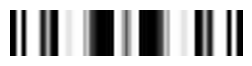


--- Iter 120 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.860
FoM values: [0.08134606177035178, 0.994847255118065, 0.08134606177035243]
Mean FoM: 0.385846
Binarization degree: 0.7199


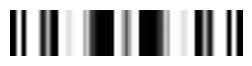


--- Iter 121 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.860
FoM values: [0.07953975366541016, 0.9903902644956769, 0.07953975366541072]
Mean FoM: 0.383157
Binarization degree: 0.7188


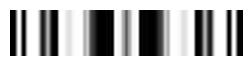


--- Iter 122 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.860
FoM values: [0.07740493189402528, 0.9696531008022822, 0.07740493189402581]
Mean FoM: 0.374821
Binarization degree: 0.7180


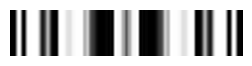


--- Iter 123 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.860
FoM values: [0.07435093764048266, 0.937841079910704, 0.07435093764048303]
Mean FoM: 0.362181
Binarization degree: 0.7174


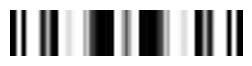


--- Iter 124 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.860
FoM values: [0.07564072731603606, 0.9336524732114023, 0.0756407273160365]
Mean FoM: 0.361645
Binarization degree: 0.7179


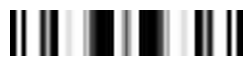


--- Iter 125 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.860
FoM values: [0.07842359063544695, 0.9671050669013618, 0.0784235906354475]
Mean FoM: 0.374651
Binarization degree: 0.7179


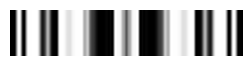


--- Iter 126 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.860
FoM values: [0.08266259490441229, 1.0008568938440972, 0.0826625949044129]
Mean FoM: 0.388727
Binarization degree: 0.7190


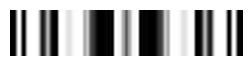


--- Iter 127 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.860
FoM values: [0.08381752374148656, 0.9977624676723807, 0.08381752374148717]
Mean FoM: 0.388466
Binarization degree: 0.7200


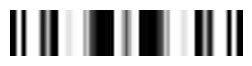


--- Iter 128 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.08493134138636803, 0.9980672511793965, 0.08493134138636865]
Mean FoM: 0.389310
Binarization degree: 0.7204


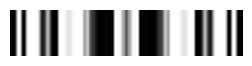


--- Iter 129 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.0831032792310898, 0.9449825048575741, 0.08310327923109016]
Mean FoM: 0.370396
Binarization degree: 0.7330


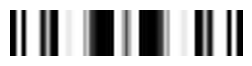


--- Iter 130 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.07480523334879348, 0.8663008139313856, 0.07480523334879417]
Mean FoM: 0.338637
Binarization degree: 0.7335


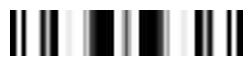


--- Iter 131 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.08099760610789707, 0.9484067036884635, 0.08099760610789805]
Mean FoM: 0.370134
Binarization degree: 0.7334


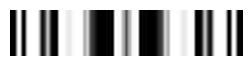


--- Iter 132 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.0791139864921347, 0.9085728106138404, 0.07911398649213505]
Mean FoM: 0.355600
Binarization degree: 0.7328


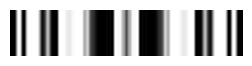


--- Iter 133 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.08342851222902983, 0.9996044343325006, 0.08342851222903064]
Mean FoM: 0.388820
Binarization degree: 0.7326


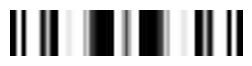


--- Iter 134 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.07598114490116101, 0.9154430083512891, 0.07598114490116178]
Mean FoM: 0.355802
Binarization degree: 0.7320


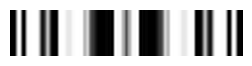


--- Iter 135 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.08149011082925885, 1.0015677581285836, 0.08149011082925936]
Mean FoM: 0.388183
Binarization degree: 0.7311


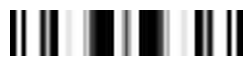


--- Iter 136 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.07718679031015832, 0.9525630150776205, 0.07718679031015857]
Mean FoM: 0.368979
Binarization degree: 0.7306


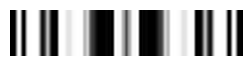


--- Iter 137 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.07498636130842522, 0.9164465711806523, 0.07498636130842579]
Mean FoM: 0.355473
Binarization degree: 0.7304


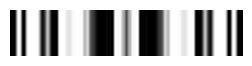


--- Iter 138 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.07956682067890315, 0.9856588212071156, 0.07956682067890328]
Mean FoM: 0.381597
Binarization degree: 0.7301


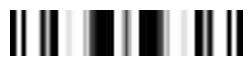


--- Iter 139 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.07185797063038535, 0.8782079741660621, 0.07185797063038546]
Mean FoM: 0.340641
Binarization degree: 0.7297


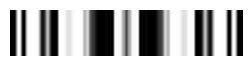


--- Iter 140 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.07815082356339013, 0.9381645579232568, 0.0781508235633903]
Mean FoM: 0.364822
Binarization degree: 0.7301


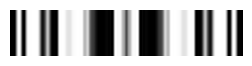


--- Iter 141 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.08146299659396607, 0.9707943975310199, 0.08146299659396641]
Mean FoM: 0.377907
Binarization degree: 0.7304


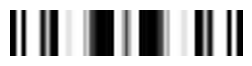


--- Iter 142 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.0795774177387423, 0.929467938837092, 0.07957741773874258]
Mean FoM: 0.362874
Binarization degree: 0.7306


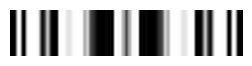


--- Iter 143 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.08681332959384003, 1.008662118672664, 0.08681332959384028]
Mean FoM: 0.394096
Binarization degree: 0.7308


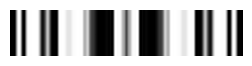


--- Iter 144 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.0824801840600987, 0.9424608423382549, 0.08248018406009947]
Mean FoM: 0.369140
Binarization degree: 0.7309


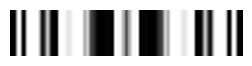


--- Iter 145 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.08780733773427267, 1.0039745031884602, 0.08780733773427297]
Mean FoM: 0.393196
Binarization degree: 0.7310


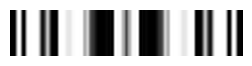


--- Iter 146 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.08514098134985332, 0.9622532521023295, 0.0851409813498539]
Mean FoM: 0.377512
Binarization degree: 0.7310


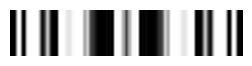


--- Iter 147 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.08784717342412413, 1.0094654312036084, 0.08784717342412456]
Mean FoM: 0.395053
Binarization degree: 0.7309


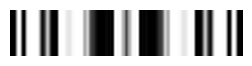


--- Iter 148 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.08344017971174439, 0.9660235642107655, 0.08344017971174476]
Mean FoM: 0.377635
Binarization degree: 0.7308


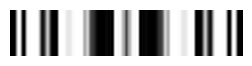


--- Iter 149 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.08633787915701611, 1.0151484877286125, 0.08633787915701657]
Mean FoM: 0.395941
Binarization degree: 0.7304


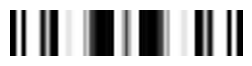


--- Iter 150 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.08270352447654862, 0.9802528532076975, 0.08270352447654926]
Mean FoM: 0.381887
Binarization degree: 0.7301


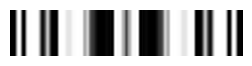

In [29]:
n = Nx * layer_num
np.random.seed(3)           
x = 0.4 + 0.2 * np.random.rand(n)  

cur_beta = 2

cur_iter             = [0]
evaluation_history   = []
beta_history         = []
binarization_history = []

g_histories   = [[] for _ in range(layer_num)]
x_histories   = [[] for _ in range(layer_num)]
lr_histories  = [[] for _ in range(layer_num)]
uf_histories  = [[] for _ in range(layer_num)]
t_histories   = [[] for _ in range(layer_num)]

optimizers = [AdamOptimizer(lr=0.02, beta1=0.9) for _ in range(layer_num)]

def f_multi(v, eta, beta):
    print(f"\n--- Iter {cur_iter[0]+1} ---")

    rho_full = multi_mapping(v, eta, beta)

    bin_deg = np.sum(np.abs(rho_full - 0.5)) / (0.5 * rho_full.size)
    binarization_history.append(bin_deg)

    size_each = Nx * Ny
    rho_list = [rho_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]

    f0_list = []
    dJ_list = []
    for i in range(len(opt_list)):
        f0_i, dJ_i = opt_list[i]([rho_full], need_value=True, need_gradient=True, beta=beta)
        f0_list.append(f0_i.flatten())
        dJ_list.append(dJ_i)

    dJ_total = np.mean(dJ_list, axis=0) # -> 3번째 트라이 바꾸는 부분
    dJ_flat = np.array(dJ_total).flatten()

    gradient_full = tensor_jacobian_product(multi_mapping, 0)(v, eta, beta, dJ_flat)

    grad_list = [gradient_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]
    vs = v.reshape(layer_num, size_each)
    v_new_layers = []
    for i in range(layer_num):
        vi_new, lr, uf, m, vt, t = optimizers[i].update(vs[i], grad_list[i])
        lr_histories[i].append(lr)
        uf_histories[i].append(uf)
        t_histories[i].append(t)
        g_histories[i].append(grad_list[i].copy())
        x_histories[i].append(vi_new.copy())
        v_new_layers.append(vi_new)
    v_new = np.concatenate(v_new_layers)

    f_vals = [float(np.real(f0).item()) for f0 in f0_list]
    evaluation_history.append(f_vals)

    beta_history.append(beta)
    cur_iter[0] += 1

    if len(evaluation_history) >= 3:
        f_prev2 = evaluation_history[-3]
        f_prev1 = evaluation_history[-2]
        f_curr  = evaluation_history[-1]

        bin_prev2 = binarization_history[-3]
        bin_prev1 = binarization_history[-2]
        bin_curr  = binarization_history[-1]

        # 평균 FoM 기준 변화율 계산 (💡 여기 수정!)
        change1 = abs(np.mean(f_curr)  - np.mean(f_prev1)) / (abs(np.mean(f_prev1)) + 1e-12)
        change2 = abs(np.mean(f_prev1) - np.mean(f_prev2)) / (abs(np.mean(f_prev2)) + 1e-12)

        bin_change1 = abs(bin_curr  - bin_prev1) / (abs(bin_prev1) + 1e-12)
        bin_change2 = abs(bin_prev1 - bin_prev2) / (abs(bin_prev2) + 1e-12)

        if (change1 < 0.005 and change2 < 0.005) and (bin_change1 < 0.002 and bin_change2 < 0.002):
            beta = beta + 12*np.tanh((beta - 0.5)*0.01)

    print(f"Current β: {beta:.3f}")
    print("FoM values:", f_vals)
    print(f"Mean FoM: {np.mean(f_vals):.6f}")

    print(f"Binarization degree: {bin_deg:.4f}")

    plt.figure(figsize=(3, 2))
    ax = plt.gca()
    opt_list[0].plot2D(
        False,
        output_plane=mp.Volume(
            size=mp.Vector3(design_region_width, region_height_each * layer_num - 1 / resolution, 0),
            center=mp.Vector3(0, full_center_y, 0)
        ),
        ax=ax,
        show_sources=False,
        show_monitors=False,
        show_boundary_layers=False,
    )
    ax.axis("off")
    plt.show()

    return v_new, beta

mp.verbosity(0)
Max_iter = 150

while cur_iter[0] < Max_iter:
    x, cur_beta = f_multi(x, eta_i, cur_beta)
    if binarization_history[-1] > 0.98:
        print("Threshold reached → final mapping with β=∞")
        x, _ = f_multi(x, eta_i, np.inf)
        break

최대 FoM = 1.015148 는 iteration 446 에서 나왔습니다.


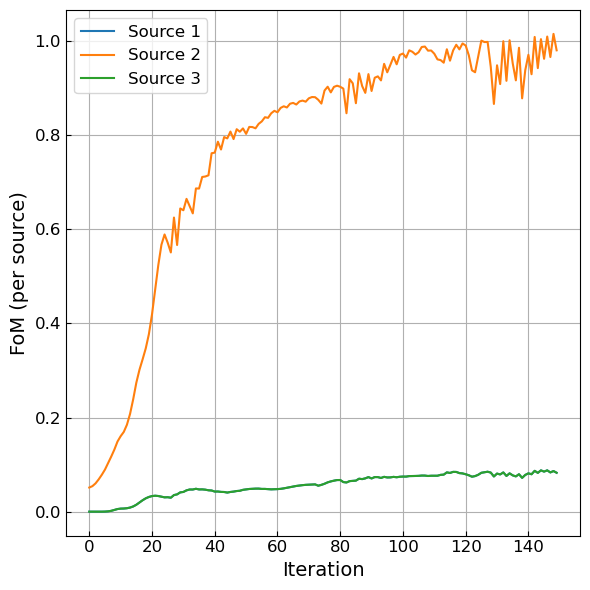

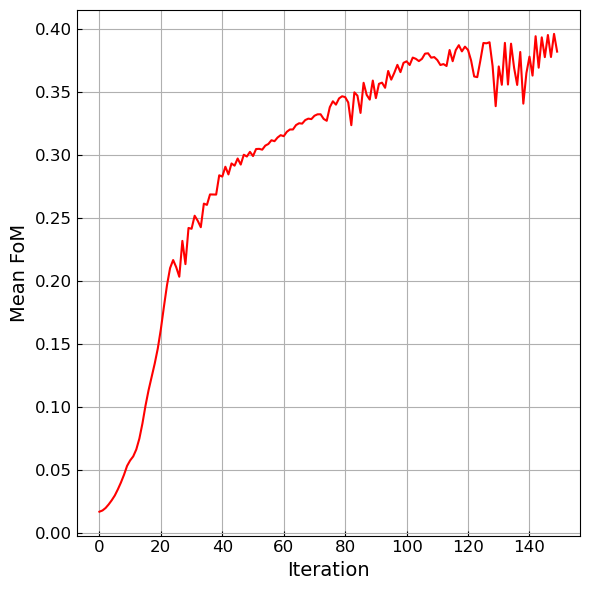

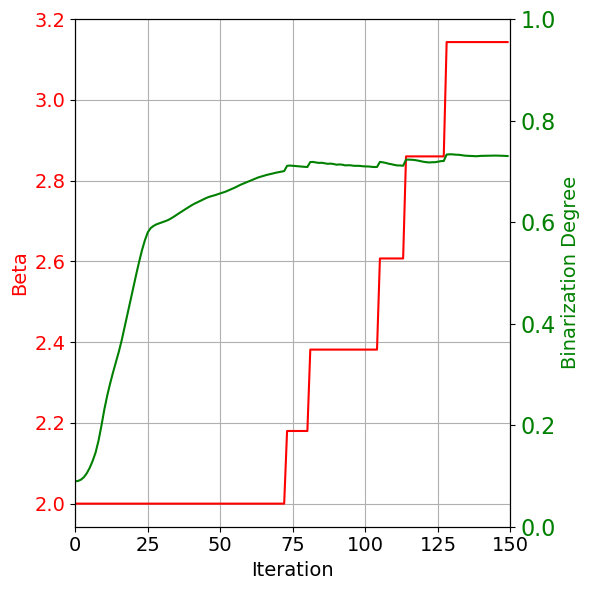

In [30]:
################ Find best FOM ################ 
eval_hist = np.array(evaluation_history)
max_val   = eval_hist.max()
max_idx0  = eval_hist.argmax()
iteration = max_idx0 + 1

print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")

################ FOM plot ################ 
evaluation_array = np.array(evaluation_history)  
iterations = np.arange(len(evaluation_history))

###################### [1] 각 소스별 FoM plot ######################
plt.figure(figsize=(6, 6))

for i in range(evaluation_array.shape[1]):  # 각 소스별
    plt.plot(iterations, evaluation_array[:, i], label=f"Source {i+1}")

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('FoM (per source)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

###################### [2] 평균 FoM plot ######################
plt.figure(figsize=(6, 6))

mean_fom = evaluation_array.mean(axis=1)  # 평균 FoM 계산
plt.plot(iterations, mean_fom, 'r-', label='Mean FoM')

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Mean FoM', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.tight_layout()
plt.show()

################ Combined Beta and Binarization Degree Plot ################ 
fig, ax1 = plt.subplots(figsize=(6,6))

color1 = 'red'
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('Beta', color=color1, fontsize=14)
ax1.plot(beta_history, color=color1, label='Beta History')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim(0, np.array(cur_iter))
ax1.tick_params(labelsize=14)
ax1.grid(True)

ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Binarization Degree', color=color2, fontsize=14)
ax2.plot(binarization_history, color=color2, linestyle='-', label='Binarization Degree')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0.4, 1)
ax2.set_ylim(0, 1)
ax2.tick_params(labelsize=16)

fig.tight_layout()
# plt.title('Beta & Binarization Degree', fontsize=15)
plt.show()

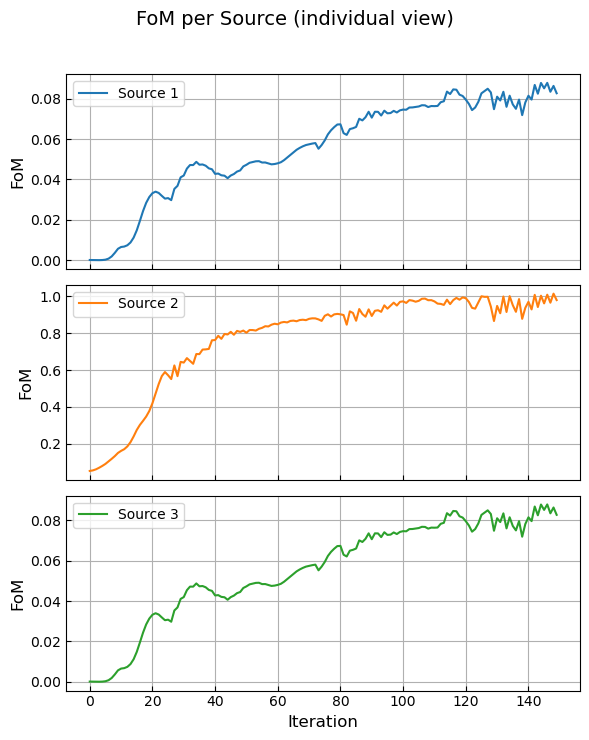

In [31]:
###################### [1-2] 각 소스별 FoM 개별 subplot ######################
num_sources = evaluation_array.shape[1]

fig, axs = plt.subplots(num_sources, 1, figsize=(6, 2.5*num_sources), sharex=True)

for i in range(num_sources):
    axs[i].plot(iterations, evaluation_array[:, i], label=f"Source {i+1}", color=f"C{i}")
    axs[i].set_ylabel("FoM", fontsize=12)
    axs[i].legend(fontsize=10)
    axs[i].grid(True)
    axs[i].tick_params(labelsize=10, direction='in')

axs[-1].set_xlabel("Iteration", fontsize=12)
fig.suptitle("FoM per Source (individual view)", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [196]:
# k = design_variables.weights
# np.savetxt("Dipole_sum.txt", k)
design_load = np.loadtxt("Dipole_sum.txt")
for i in range(len(sources)):
    opt_list[i].update_design([design_load])

Plotting geometry for Source 1


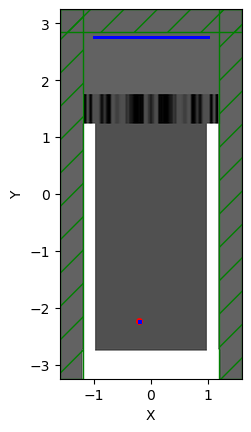

Plotting geometry for Source 2


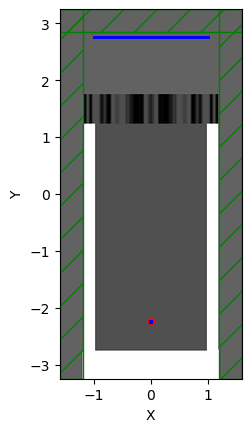

Plotting geometry for Source 3


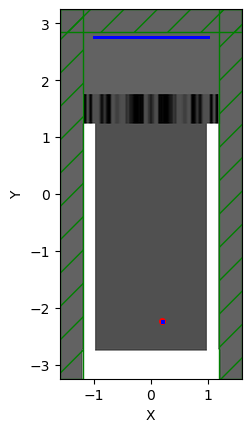

In [197]:
offset = 0.01
flux_size = 0.02
mn_size = 2

monitor_position_y = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(mn_size, 0)

input_flux_list = []
output_flux_list = []
dft_fields_list = []

for i in range(len(sources)):
    

    sim_i = opt_list[i].sim
    source_i = sources[i]

    input_flux = sim_i.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=source_i.center - mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size),
                      weight=-1),
        mp.FluxRegion(center=source_i.center + mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size)),
        mp.FluxRegion(center=source_i.center - mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0),
                      weight=-1),
        mp.FluxRegion(center=source_i.center + mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0))
    )
    input_flux_list.append(input_flux)

    output_flux = sim_i.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=monitor_position_y,
                      size=monitor_size)
    )
    output_flux_list.append(output_flux)

    dft_fields = sim_i.add_dft_fields(
        [mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz],
        fcen, 0, 1,
        center=monitor_position_y,
        size=monitor_size,
        yee_grid=True
    )
    dft_fields_list.append(dft_fields)

    print(f"Plotting geometry for Source {i+1}")
    opt_list[i].plot2D()
    plt.show()


🔄 Iteration 시작 전 초기화: Source 1
▶️ Running Simulation for Source 1
📊 Plotting 2D Ez for Source 1


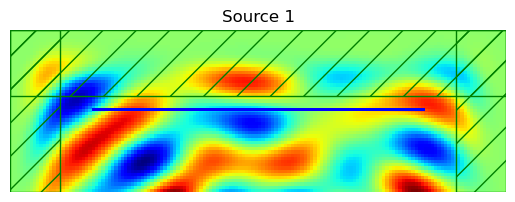

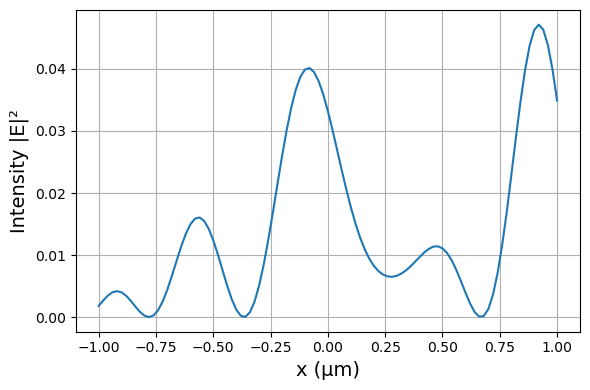


🔍 Source 1
  Input  flux : 0.105686
  Output flux : 0.065630
  EQE (%)     : 62.10 %

🔄 Iteration 시작 전 초기화: Source 2
▶️ Running Simulation for Source 2
📊 Plotting 2D Ez for Source 2


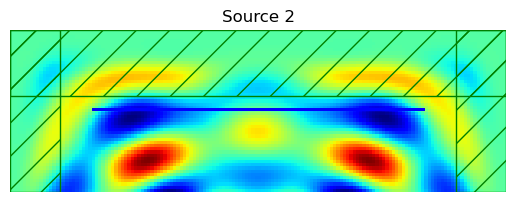

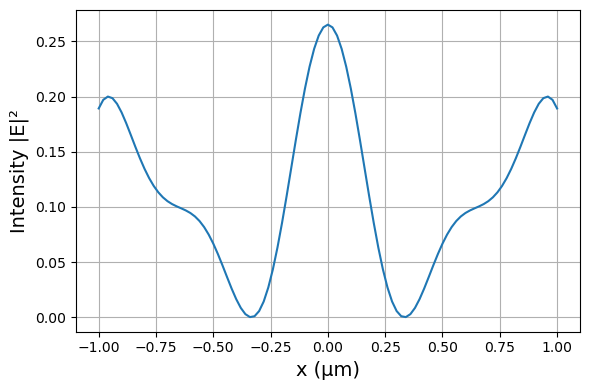


🔍 Source 2
  Input  flux : 1.049886
  Output flux : 0.703761
  EQE (%)     : 67.03 %

🔄 Iteration 시작 전 초기화: Source 3
▶️ Running Simulation for Source 3
📊 Plotting 2D Ez for Source 3


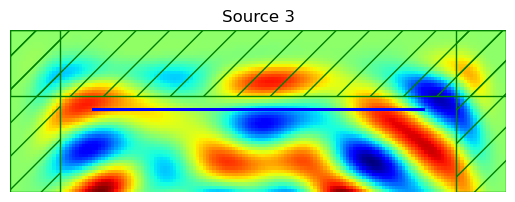

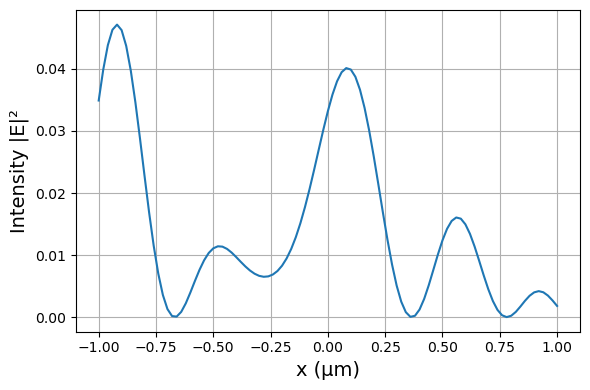


🔍 Source 3
  Input  flux : 0.105686
  Output flux : 0.065630
  EQE (%)     : 62.10 %

=== Summary EQE per source ===
Source 1: EQE = 62.10 %
Source 2: EQE = 67.03 %
Source 3: EQE = 62.10 %


In [198]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# verbosity off
mp.verbosity(0)

# parameters
offset    = 0.01
flux_size = 0.02
mn_size   = 2

monitor_position_y = mp.Vector3(0, center_y_monitor_position)
monitor_size       = mp.Vector3(mn_size, 0)

# prepare storage
input_flux_list  = []
output_flux_list = []
dft_fields_list  = []
eqe_list         = []

# loop over sims & sources
for i, (sim, src) in enumerate(zip(sims, sources), start=1):
    print(f"\n🔄 Iteration 시작 전 초기화: Source {i}")
    sim.reset_meep()

    # add input flux monitor around the dipole
    input_flux = sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=src.center - mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size), weight=-1),
        mp.FluxRegion(center=src.center + mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size)),
        mp.FluxRegion(center=src.center - mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0), weight=-1),
        mp.FluxRegion(center=src.center + mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0))
    )
    input_flux_list.append(input_flux)

    # add output flux monitor at the planar monitor position
    output_flux = sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=monitor_position_y,
                      size=monitor_size)
    )
    output_flux_list.append(output_flux)

    # add DFT field monitor
    dft_fields = sim.add_dft_fields(
        [mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz],
        fcen, 0, 1,
        center=monitor_position_y,
        size=monitor_size,
        yee_grid=True
    )
    dft_fields_list.append(dft_fields)

    # run until fields decayed
    print(f"▶️ Running Simulation for Source {i}")
    sim.run(
        # until_after_sources=mp.stop_when_fields_decayed(
        #     10/df, mp.Ez, src.center, 1e-5
        # )
        until = 300
    )

    # spatial plot of Ez
    print(f"📊 Plotting 2D Ez for Source {i}")
    sim.plot2D(
        fields=mp.Ez,
        output_plane=mp.Volume(center=monitor_position_y,
                               size=mp.Vector3(3,1)),
        field_parameters={'post_process': lambda x: np.real(x),
                          'cmap': 'jet', 'alpha': 1,
                          'interpolation': 'none'},
        eps_parameters={'cmap':'magma','alpha':0.8}
    )
    plt.axis(False)
    plt.title(f"Source {i}", fontsize=12)
    plt.show()

    # 1D intensity profile from DFT
    E_line = np.real(sim.get_dft_array(dft_fields, mp.Ez, 0))
    x = np.linspace(-mn_size/2, mn_size/2, E_line.size)
    I = np.abs(E_line)**2

    plt.figure(figsize=(6,4))
    plt.plot(x, I, label=f"Source {i}")
    plt.xlabel('x (µm)', fontsize=14)
    plt.ylabel('Intensity |E|²', fontsize=14)
    # plt.title(f"Source {i} – Monitor size: {mn_size}µm", fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # compute EQE
    Pin  = mp.get_fluxes(input_flux)[0]
    Pout = mp.get_fluxes(output_flux)[0]
    eqe  = 100 * Pout/Pin
    eqe_list.append(eqe)

    print(f"\n🔍 Source {i}")
    print(f"  Input  flux : {Pin:.6f}")
    print(f"  Output flux : {Pout:.6f}")
    print(f"  EQE (%)     : {eqe:.2f} %")

# print summary
print("\n=== Summary EQE per source ===")
for i, val in enumerate(eqe_list, start=1):
    print(f"Source {i}: EQE = {val:.2f} %")


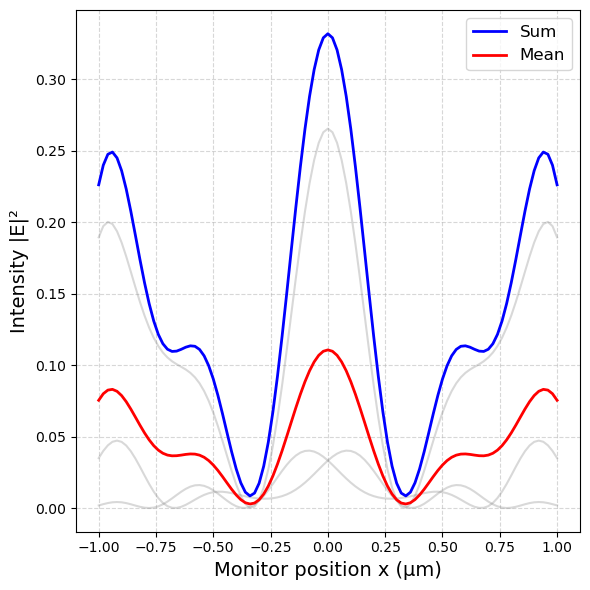

In [199]:
import numpy as np
import matplotlib.pyplot as plt

# === 0) I_profiles 수집용 리스트 초기화 ===
I_profiles = []

# === 1) 각 sim에서 1D intensity 프로파일 계산 & 저장 ===
for sim, dft in zip(sims, dft_fields_list):
    # (이미 sim.run(...) 이 완료된 상태여야 합니다)
    E_line = np.real(sim.get_dft_array(dft, mp.Ez, 0))  # 1D 배열 
    I = np.abs(E_line)**2                              # intensity
    I_profiles.append(I)

# === 2) x 좌표 벡터 생성 ===
N = I_profiles[0].size
x = np.linspace(-mn_size/2, mn_size/2, N)

# === 3) 합(sum) 및 평균(mean) 프로파일 계산 ===
I_stack = np.vstack(I_profiles)   # shape = (num_sources, N)
I_sum   = I_stack.sum(axis=0)     # 각 x 위치별 합
I_mean  = I_stack.mean(axis=0)    # 각 x 위치별 평균

# === 4) 한 그래프에 개별·합·평균 모두 그리기 ===
plt.figure(figsize=(6,6))

# (가) 개별 소스 프로파일: 연회색 얇은 선
for I in I_profiles:
    plt.plot(x, I, color='gray', alpha=0.3)

# (나) 합 프로파일: 검정 두꺼운 선
plt.plot(x, I_sum, 'b-', lw=2, label='Sum')

# (다) 평균 프로파일: 빨강 두꺼운 선
plt.plot(x, I_mean, 'r-', lw=2, label='Mean')

plt.xlabel('Monitor position x (µm)', fontsize=14)
plt.ylabel('Intensity |E|²', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


적분 범위: ±0.340 µm → P_total(1차 링까지) = 0.037857


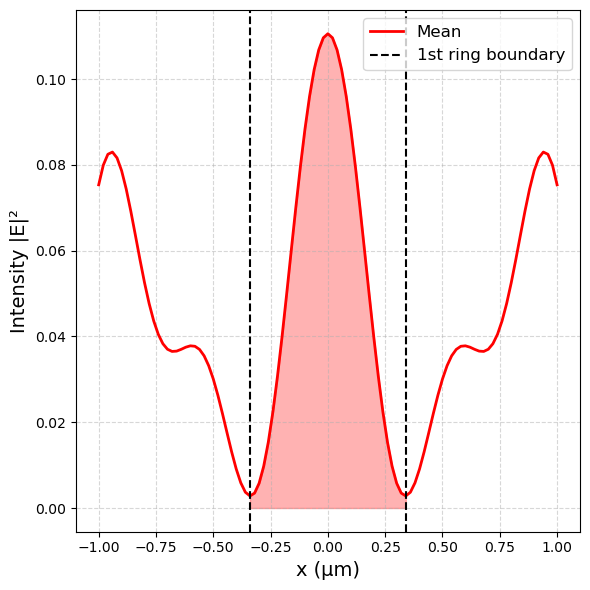

In [204]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- 0) I_profiles & x, I_mean 계산 (생략 가능) ---
I_profiles = []
for sim, dft in zip(sims, dft_fields_list):
    Ez_line = np.real(sim.get_dft_array(dft, mp.Ez, 0))
    I_profiles.append(np.abs(Ez_line)**2)

N       = I_profiles[0].size
x       = np.linspace(-mn_size/2, mn_size/2, N)
I_stack = np.vstack(I_profiles)
I_mean  = I_stack.mean(axis=0)   # sum 으로 되어 있던 부분 그대로

# --- 1) "진짜 중앙" 피크 찾기 ---
peaks, _ = find_peaks(I_mean)
if len(peaks)==0:
    center_idx = np.argmax(I_mean)
else:
    center_idx = peaks[np.argmin(np.abs(x[peaks]))]

# --- 2) 중앙 이후 첫 번째 · 두 번째 국소 최소점 검출 ---
minima_idx = []
for j in range(center_idx+1, N-1):
    if I_mean[j] < I_mean[j-1] and I_mean[j] < I_mean[j+1]:
        minima_idx.append(j)
        if len(minima_idx) >= 2:
            break

ring1_idx = minima_idx[0] if len(minima_idx)>0 else None
# ring2_idx = minima_idx[1] if len(minima_idx)>1 else None  # 더 이상 사용 안 함

x_ring1 = abs(x[ring1_idx]) if ring1_idx is not None else mn_size/2
# x_ring2 = abs(x[ring2_idx]) if ring2_idx is not None else mn_size/2

# --- 3) 적분 범위를 1차 링까지로 한정 ---
mask_total = (np.abs(x) <= x_ring1)   # <-- 2차 대신 1차 링까지
P_total    = np.trapz(I_mean[mask_total], x[mask_total])

# (원한다면 1차 링 내 세기도 별도 계산)
mask1 = mask_total
P1     = P_total
eff1   = 100.0  # P1 / P_total * 100 이므로 항상 100%

# --- 4) 결과 출력 ---
print(f"적분 범위: ±{x_ring1:.3f} µm → P_total(1차 링까지) = {P_total:.6f}")
# print(f"1차 링 내 세기 P1 = {P1:.6f}, 효율 = {eff1:.2f}%")

# --- 5) 시각화 ---
plt.figure(figsize=(6,6))
plt.plot(x, I_mean, 'r-', lw=2, label='Mean')
plt.axvline(-x_ring1, ls='--', color='k', label='1st ring boundary')
plt.axvline(+x_ring1, ls='--', color='k')

plt.fill_between(x, I_mean, where=mask_total,
                 interpolate=True,
                 color='red', alpha=0.3)

plt.xlabel('x (µm)', fontsize=14)
plt.ylabel('Intensity |E|²', fontsize=14)
plt.legend(fontsize=12)
plt.grid(ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


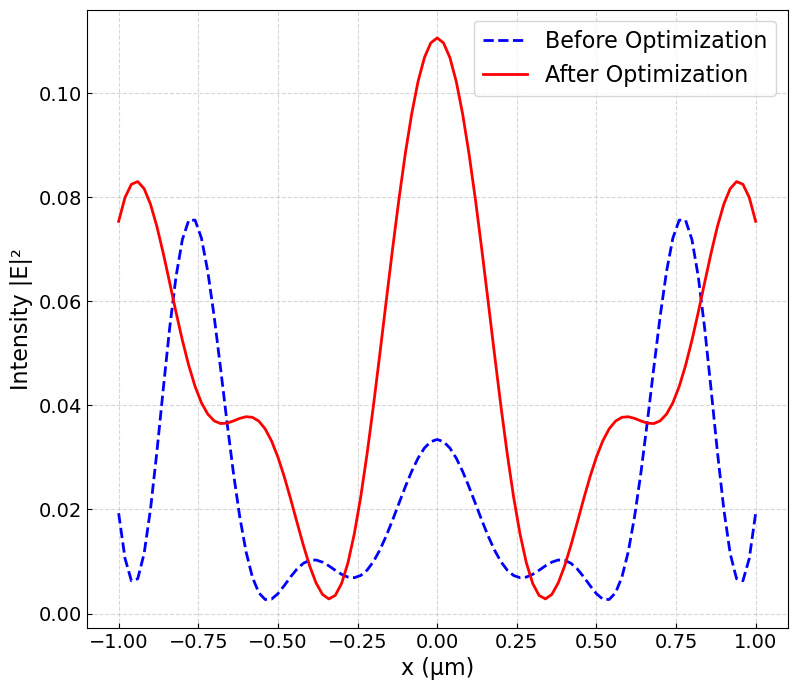

Average efficiency (Current/Saved mean): 351.32%


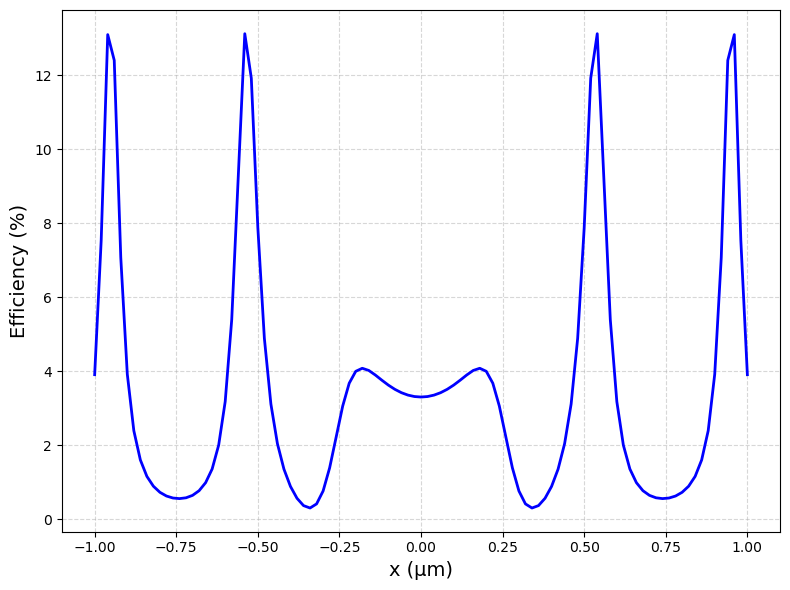

In [205]:
import numpy as np
import matplotlib.pyplot as plt

file_path = '/home/min/EIDL/Tool/Meep/LGD/LGD setup/Mode decomposition/Kyungmin/2025/07/22/Postprocess/combined_intensity.txt'

data = np.loadtxt(file_path)
x_loaded, I_sum_loaded, I_mean_loaded = data.T
plt.figure(figsize=(8,7))

plt.plot(x_loaded, I_mean_loaded, 'b--', lw=2, label='Before Optimization')

plt.plot(x, I_mean, 'r-', lw=2, label='After Optimization')

plt.xlabel('x (µm)', fontsize=16)
plt.ylabel('Intensity |E|²', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tick_params(direction = 'in')
plt.show()

eff_line = (I_mean / I_mean_loaded) 

avg_eff = np.mean(eff_line)* 100
print(f"Average efficiency (Current/Saved mean): {avg_eff:.2f}%")

plt.figure(figsize=(8,6))
plt.plot(x_loaded, eff_line, 'b-', lw=2)
plt.xlabel('x (µm)', fontsize=14)
plt.ylabel('Efficiency (%)', fontsize=14)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

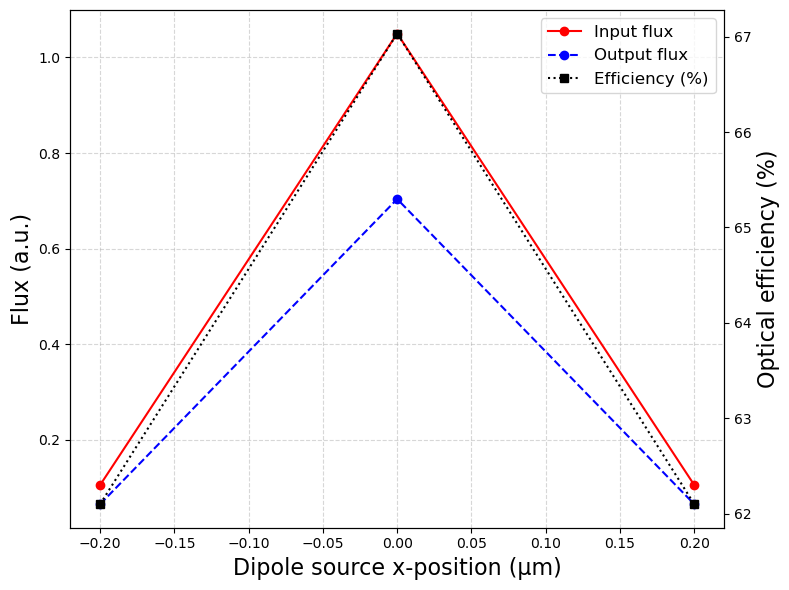

In [173]:
positions      = [src.center.x for src in sources]
input_values   = [mp.get_fluxes(f)[0] for f in input_flux_list]
output_values  = [mp.get_fluxes(f)[0] for f in output_flux_list]
percent_values = [100 * outv / inv if inv != 0 else 0
                  for inv, outv in zip(input_values, output_values)]

fig, ax1 = plt.subplots(figsize=(8,6))

# 왼쪽 축에 입력/출력 flux
ax1.plot(positions, input_values,  'ro-', label='Input flux')
ax1.plot(positions, output_values, 'bo--', label='Output flux')
ax1.set_xlabel('Dipole source x-position (µm)', fontsize=16)
ax1.set_ylabel('Flux (a.u.)',              fontsize=16, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='both', ls='--', alpha=0.5)

# 오른쪽 축에 효율
ax2 = ax1.twinx()
ax2.plot(positions, percent_values, 'ks:', label='Efficiency (%)')
ax2.set_ylabel('Optical efficiency (%)', fontsize=16, color='k')
ax2.tick_params(axis='y', labelcolor='k')

# 범례 합치기
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=12)

plt.tight_layout()
plt.show()


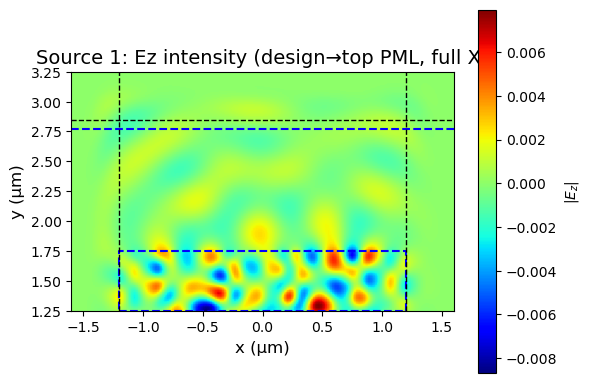

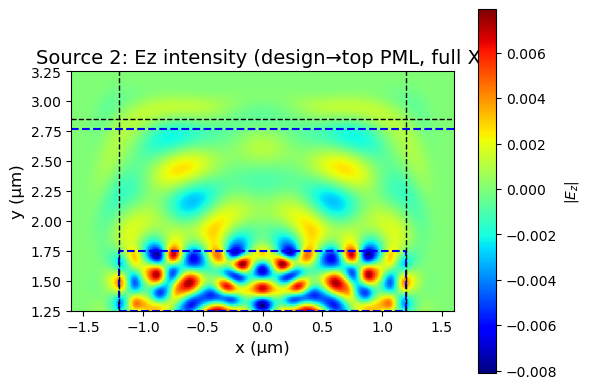

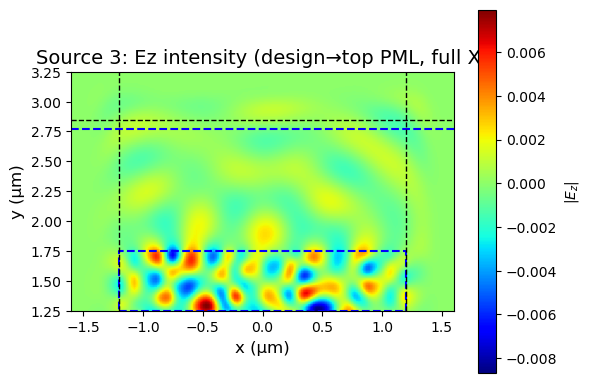

In [164]:
# 1) Y 범위: 디자인 영역 바닥→상단 PML 끝 (기존과 동일)
y_design_bot = center_y_design - design_region_height/2
y_start     = y_design_bot
y_end       = Sy/2

# 2) X 범위: 셀 전체 폭 (PML 포함)
x_start = -Sx/2
x_end   =  Sx/2

# 3) 해상도 벡터 재계산
nx   = int(resolution * Sx) + 1
x_res = np.linspace(x_start, x_end, nx)

ny   = int(resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

# 4) Volume 정의: X=Sx, Y=y_end–y_start
vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=mp.Vector3(Sx, y_end - y_start, 0)
)

# 5) 플롯 루프
# 5) 플롯 루프
for i in range(num_sources):
    Ez_slice = opt_list[i].sim.get_array(mp.Ez, vol).T
    I = np.real(Ez_slice)
    
    # I_max = np.max(np.real(Ez_slice))
    # I = np.real(Ez_slice)/I_max

    plt.figure(figsize=(6,4))
    plt.imshow(
        I,
        origin='lower',
        extent=[x_start, x_end, y_start, y_end],
        aspect='equal',
        cmap='jet'
    )
    plt.colorbar(label=r'$|E_z|$')
    plt.title(f"Source {i+1}: Ez intensity (design→top PML, full X)", fontsize=14)
    plt.xlabel('x (µm)', fontsize=12)
    plt.ylabel('y (µm)', fontsize=12)

    # — 디자인 영역 표시 —
    x0, x1 = -design_region_width/2, design_region_width/2
    y0 = y_design_bot
    y1 = y_design_bot + design_region_height
    plt.plot(
        [x0, x1, x1, x0, x0],
        [y0, y0, y1, y1, y0],
        'b--', lw=1.5, label='Design region'
    )

    # — 모니터 평면 표시 —
    plt.axhline(center_y_monitor_position, color='blue',
                ls='--', lw=1.5, label='Monitor plane')

    # — PML 경계 표시 (점선) —
    # 수평 PML 경계
    # plt.axhline(y_start + tpml,          color='yellow', ls='--', lw=1, label='Bottom PML end')
    plt.axhline(y_end   - tpml,          color='k', ls='--', lw=1, label='Top PML start')
    # 수직 PML 경계
    plt.axvline(x_start + tpml,          color='k', ls='--', lw=1, label='Left PML end')
    plt.axvline(x_end   - tpml,          color='k', ls='--', lw=1, label='Right PML start')

    # — 축범위 고정 —
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)

    # plt.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.show()



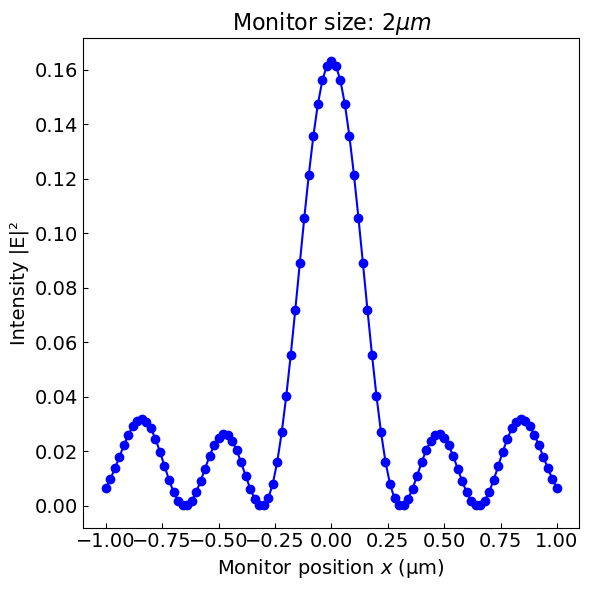

In [185]:
external_field_array = np.real(sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

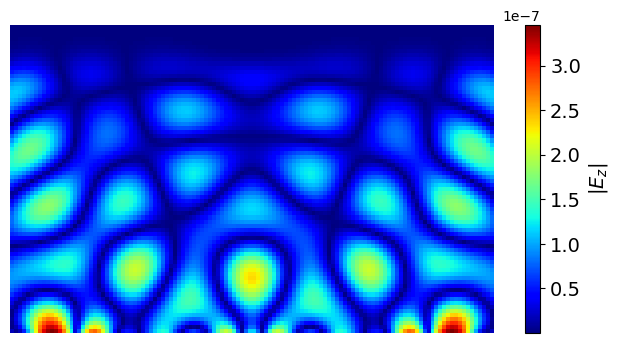

In [204]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

nx = int(design_region_resolution * design_region_width) + 1
x_res = np.linspace(-design_region_width/2,
                     design_region_width/2,
                     nx)

y_start = center_y_design + design_region_height/2
y_end   = center_y_monitor_position + 1/fcen
ny = int(design_region_resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=  mp.Vector3(design_region_width,
                      y_end - y_start,
                      0)
)
Ez_slice = opt_list[2].sim.get_array(mp.Ez, vol).T   # shape == (ny, nx)

plt.figure(figsize=(8,4))
plt.imshow(
    np.abs(Ez_slice),      # (ny, nx)
    origin='lower',
    extent=[x_res.min(), x_res.max(), y_res.min(), y_res.max()],
    aspect='equal',
    cmap='jet'
)

cbar = plt.colorbar()
cbar.set_label(r'$|E_z|$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
# plt.ylabel('Height $y$ (µm)',           fontsize=14)
# plt.title(r'Monitor size: $2\ \mu m$',   fontsize=16)

# 틱 폰트 크기 및 방향 맞추기
plt.tick_params(direction='in', labelsize=14)
# plt.tight_layout()
plt.axis('off')
plt.show()

#### 소스 위치나 모니터 위치, 구조물 등등)

In [77]:
input = np.mean([mp.get_fluxes(flux)[0] for flux in input_flux_list])
print("Input되고 있는 flux : ", input)

NameError: name 'input_flux_list' is not defined

In [ ]:
import numpy as np

I = np.real(external_field_array)**2
N = len(I)
W = mn_size
x = np.linspace(-W/2, W/2, N)
z = abs(center_y_monitor_position - center_y_source_position)

center_idx = np.argmax(I)
# 간단히 for문으로
for i in range(center_idx+1, N-1):
    if I[i] < I[i-1] and I[i] < I[i+1]:
        x_limit = abs(x[i])
        break
else:
    raise RuntimeError("1차 링 경계를 찾을 수 없음")

x_min, x_max = -x_limit, x_limit

mask = (x >= x_min) & (x <= x_max)

x_slice = x[mask]
I_slice = I[mask]

dx = x[1] - x[0]
flux_slice = np.sum(I_slice) * dx   

input = np.mean([mp.get_fluxes(flux)[0] for flux in input_flux_list])
output = np.array(mp.get_fluxes(out_flux))[0]

print("Input flux :", input)
print("Output flux :", output)
print(f"±{x_limit:.3f} µm 구간 integrated intensity: {flux_slice}")

optical_eqe = flux_slice/input * 100
print("1차 ring까지의 Optical EQE :", optical_eqe,"%")

AttributeError: 'numpy.float64' object has no attribute 'flux'

In [26]:
import numpy as np

# 1) 강도 계산
I = np.abs(external_field_array)**2
N = len(I)
W = mn_size
x = np.linspace(-W/2, W/2, N)
center_idx = np.argmax(I)

# 2) 첫 번째 링 경계: 미분으로 valley 찾기
dI = np.diff(I)
valleys = np.where((dI[:-1] < 0) & (dI[1:] > 0))[0] + 1
valleys = valleys[valleys > center_idx]
if valleys.size == 0:
    raise RuntimeError("1차 링 경계를 찾을 수 없음")
idx_valley = valleys[0]
x_limit = abs(x[idx_valley])

# 3) 적분 구간 설정
mask = (x >= -x_limit) & (x <= x_limit)
dx = x[1] - x[0]
flux_slice = np.sum(I[mask]) * dx

# 4) Flux 모니터 값
input_flux  = np.array(mp.get_fluxes(input_flux))[0]
output_flux = np.array(mp.get_fluxes(out_flux))[0]

# 5) Optical EQE 계산: 출력 flux 비율을 사용
optical_eqe = output_flux / input_flux * 100

print(f"±{x_limit:.3f} µm 구간 intensity 적분: {flux_slice:.4f}")
print(f"모니터 기반 Optical EQE: {optical_eqe:.2f}%")


±0.320 µm 구간 intensity 적분: 1.0391
모니터 기반 Optical EQE: 75.64%


In [287]:
eqe = mp.get_fluxes(out_flux)[0]/mp.get_fluxes(input_flux)[0]*100
    
print("Input flux :", mp.get_fluxes(input_flux)[0])
print("Output flux :", mp.get_fluxes(out_flux)[0])
print("EQE(%) :", eqe,"%")

AttributeError: 'numpy.float64' object has no attribute 'flux'